In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstwobign # Kolmogorov distribution
import scipy

import torch
import pickle
import yaml

# Import local packages
from examples.norm_norm_diffuse_1d import (
    prior_pdf,
    likelihood_pdf,
    posterior_pdf,
    make_prior,
    plot_approximate_posterior,
    approximate_posterior_quantiles_against_x,
    plot_approximate_posterior_quantiles_against_x,
    plot_approximate_posterior_quantiles_diff_against_x,
    plot_approximate_posterior_hist,
    true_posterior,
    simulator,
    snpe_a_posterior_variance,
    plot_snpe_a_posterior_variance,
    plot_sequential_samples,
    get_approximate_posterior_density
)
from sbc.sbc_tools import plot_sbc_all, plot_sbc_histogram


This notebook acts as a gentle introduction to the methods used to visualize the rank statistics $\hat{R}_1, ..., \hat{R}_{N_\text{iter}}$ obtained from SBC.

Recall that the goal of SBC is to determine whether the sample rank statistics $\hat{R}_1, ..., \hat{R}_{N_\text{iter}}$ are discretely uniformly distributed on $\{0, \frac{1}{N_\text{samp}}, ..., \frac{N_\text{samp}-1}{N_\text{samp}}, 1\}$. We do this by comparing a histogram or a barplot or the empirical CDF (ECDF) of the ranks to what is expected under uniformity. Thus, the null hypothesis is that the ranks are discretely uniformly distributed, meaning:

- If we reject the null hypothesis, we conclude that rank statistics are not discretely uniformly distributed. Therefore, we conclude that the approximate posterior $\tilde{\pi}$ is incorrect. There is 1 source of error here: the error arising from the hypothesis test (we aren't SURE that the ranks are non-uniform).

- For generic test functions $f$, if we fail to reject the null hypothesis, we conclude nothing. However, for strong test functions (e.g. the oracle test function $f^*$), if the rank statistics seem uniform then this could suggest that the approximate posterior is accurate. For example, if we could somehow conclude that the sample rank statistics are uniform (which is not possible from a hypothesis test since we can only fail to reject the null, we can't accept it), then if we were using the oracle test function $f^*$, we could conclude that the approximate posterior was correct. Intuition tells us that there will exist other strong test functions that greatly narrow down the set of distributions that would pass SBC.



# ECDF Plots

We can visually inspect the uniformity of the sample rank statistics $\hat{R}_1, ..., \hat{R}_{N_\text{iter}}$ by plotting their empirical CDF:

$$\hat{F}_{N_\text{iter}}(x) := \frac{1}{N_\text{iter}} \sum_{i=1}^n \mathbb{I}\left[\hat{R}_{i} \le x \right] \hspace{5mm} \text{for  } x \in [0,1]$$

If the sample rank statistics were discretely uniformly distributed on $\{0, \frac{1}{N_\text{samp}}, ..., \frac{N_\text{samp}-1}{N_\text{samp}}, 1\}$, we would expect a step function of the form 

$$F_{\text{disc}}(x) = \frac{\lfloor N_\text{samp} x \rfloor +1}{N_\text{samp} + 1}$$

i.e. $F_{\text{disc}}(x)$ is the true CDF of the discrete uniform random variable on $\{0, \frac{1}{N_\text{samp}}, ..., \frac{N_\text{samp}-1}{N_\text{samp}}, 1\}$.



In [2]:
N_samp = 100
N_iter = 1000
unit_range = np.linspace(0,1,1000)

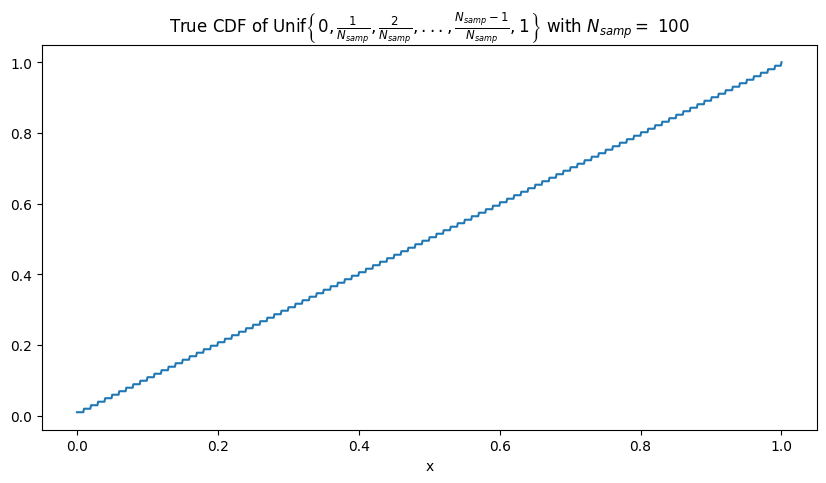

In [3]:
fig, ax = plt.subplots(figsize=(10,5))

def discrete_uniform_CDF(x, N_samp):
    return np.sum([x >= i/N_samp for i in range(0, N_samp + 1)]) / (N_samp + 1)

ax.plot(unit_range, np.vectorize(lambda x : discrete_uniform_CDF(x, N_samp))(unit_range))
ax.set_xlabel("x")
ax.set_title(r"True CDF of Unif$\left \{0, \frac{1}{N_{samp}}, \frac{2}{N_{samp}}, ..., \frac{N_{samp} - 1}{N_{samp}}, 1 \right\}$ with $N_{samp} =$ " + f"{N_samp}")
plt.show()

It is clear from the plot above that, for moderately large $N_\text{samp}$, the CDF $F_{\text{disc}}$ is well approximated by $F(x)=x$, the CDF of the continuous $\text{Unif}[0,1]$ distribution. By approximating the discrete uniform distribution as a continuous $\text{Unif}[0,1]$ distribution:

$$\hat{R}_1, ..., \hat{R}_{N_\text{iter}} \overset{\text{approx.}}{\sim} \text{Unif}[0,1]$$

$$F_{\text{disc}}(x) \approx x$$

we can invoke the result from the Kolmogorov-Smirnov test that states

$$\sqrt{n} \sup_{x \in [0,1]} \left| \hat{F}_{N_\text{iter}}(x) - x \right| \to K$$

as $N_\text{iter} \to \infty$, where $K$ follows the Kolmogorov distribution. Note that we now have two sources of approximation:

- Approximating the discrete uniform distribution $\text{Unif}\{0, \frac{1}{N_\text{samp}}, ..., \frac{N_\text{samp}-1}{N_\text{samp}}, 1\}$ as a continuous $\text{Unif}[0,1]$ distribution. This approximation becomes more exact as $N_\text{samp}$ increases.

- The fact that the Kolmogorov-Smirnov test statistic is only asymptotically distributed according to the Kolmogorov distribution. This asymptotic approximation becomes more exact as $N_\text{iter}$ increases.

Let's simulate these test statistics to see if this is a reasonable approximation to make.

In [4]:
test_statistics = []

x_grid = np.arange(0,N_samp+1) / N_samp

for i in range(10000):
    uniform_samples = np.random.randint(0,N_samp+1, N_iter) / N_samp
    empirical_cdf = np.vectorize(lambda x : np.sum(uniform_samples <= x)/N_iter)
    empirical_cdf_on_grid = empirical_cdf(x_grid)
    test_statistic = np.max(np.abs(empirical_cdf_on_grid - x_grid))
    test_statistics.append(np.sqrt(N_iter) * test_statistic)

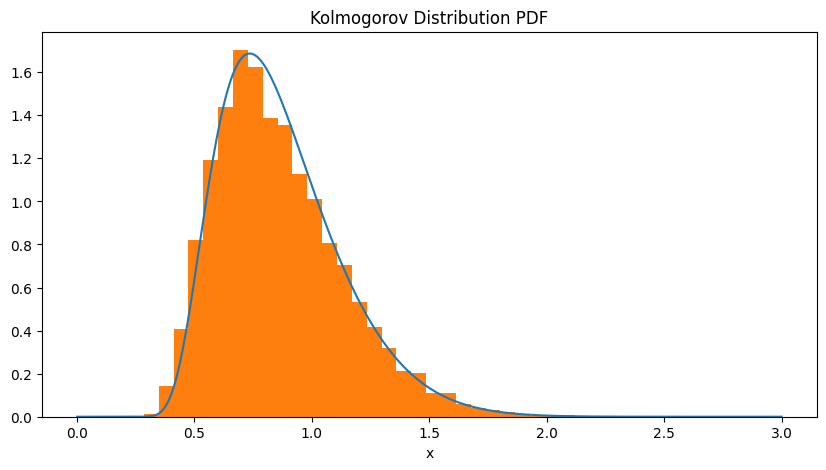

In [5]:
fig, ax = plt.subplots(figsize=(10,5))

# Define range for plotting
kolmogorov_pdf_x_range = np.linspace(0, 3, 400)

# Compute and plot PDF of the Kolmogorov distribution
kolmogorov_pdf_vals = kstwobign.pdf(kolmogorov_pdf_x_range)
ax.plot(kolmogorov_pdf_x_range, kolmogorov_pdf_vals)

# Plot histogram of test statistics
ax.hist(test_statistics, density=True, bins=30)

ax.set_title("Kolmogorov Distribution PDF")
ax.set_xlabel("x")
plt.show()

Since the test statistics seem to follow a Kolmogorov distribution, we can be confident that this approximate asymptotic result is reasonable.

Let $k_\alpha$ denote the $1-\alpha$ quantile of the Kolmogorov distribution, then we get the following approximate asymptotic one-sided probability bound:

$$\sup_{x \in [0,1]} \left| \hat{F}_{N_\text{iter}}(x) - x \right| \lesssim \frac{k_\alpha}{\sqrt{n}}$$

with probability at least $1-\alpha$. Thus, under the null hypothesis that the sample rank statistics $\hat{R}_1, ..., \hat{R}_{N_\text{iter}}$ are discretely uniform, we can say (approximately and asymptotically) that 

$$\hat{F}_{N_\text{iter}}(x) \in \left[ x - \frac{k_\alpha}{\sqrt{n}}, x + \frac{k_\alpha}{\sqrt{n}} \right] \hspace{5mm} \text{  for all } x \in [0,1]$$

with probability at least $1-\alpha$. In words, the entire empirical CDF $\{\hat{F}_{N_\text{iter}}(x) : x \in [0,1]\}$ lies in a symmetric band of width $2\frac{k_\alpha}{\sqrt{n}}$ around the line $y=x$ with probability at least $1-\alpha$.

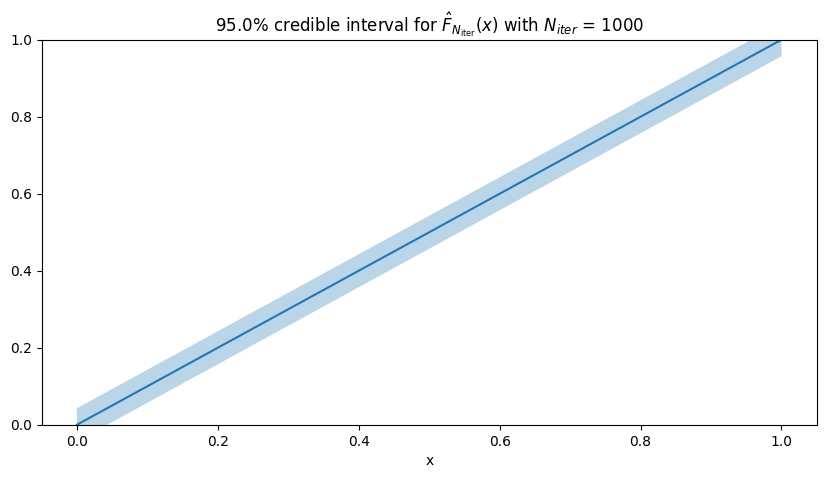

In [6]:
fig, ax = plt.subplots(figsize=(10,5))

alpha = 0.05

ax.plot(unit_range, unit_range) # y=x
ax.fill_between(unit_range,
    unit_range - kstwobign.ppf(1-alpha) / np.sqrt(N_iter),
    unit_range + kstwobign.ppf(1-alpha) / np.sqrt(N_iter),
    alpha=0.3)

ax.set_xlabel("x")
ax.set_ylim((0,1))
ax.set_title(f"{100*(1-alpha)}% credible interval for " + r"$\hat{F}_{N_\text{iter}}(x)$ with $N_{iter}$ = " + f"{N_iter}")
plt.show()

It is often more conventient to view the ECDF plot via the difference between the ECDF and the line $y=x$:

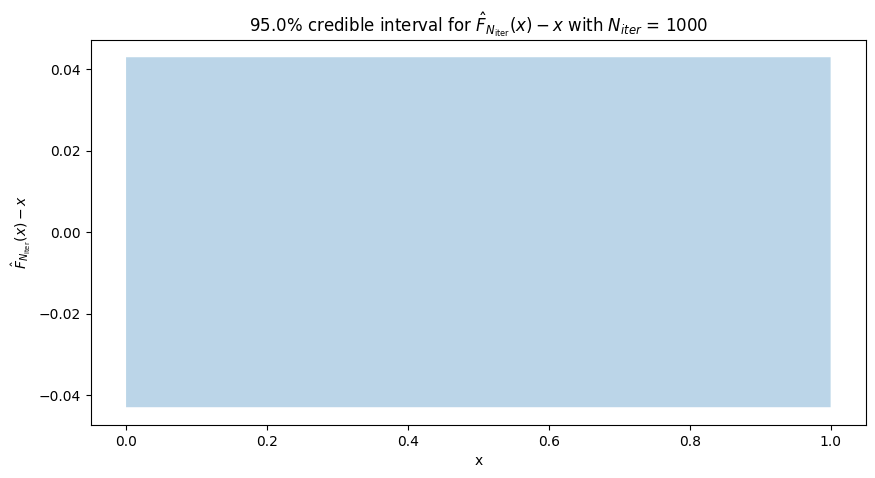

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

alpha = 0.05

ax.fill_between(unit_range,
    -1 * kstwobign.ppf(1-alpha) / np.sqrt(N_iter),
    kstwobign.ppf(1-alpha) / np.sqrt(N_iter),
    alpha=0.3)

ax.set_xlabel("x")
ax.set_ylabel(r"$\hat{F}_{N_\text{iter}}(x) - x$")
ax.set_title(f"{100*(1-alpha)}% credible interval for " + r"$\hat{F}_{N_\text{iter}}(x) - x$ with $N_{iter}$ = " + f"{N_iter}")
plt.show()

Below, we simulate $100$ realized ECDF paths. We expect roughly $5$ of then to deviate from the $95$% confidence interval.

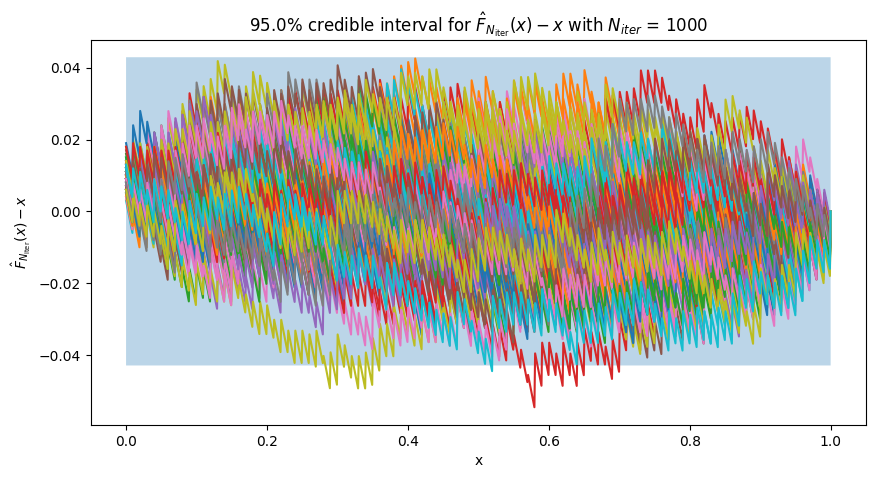

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

alpha = 0.05

ax.fill_between(unit_range,
    -1 * kstwobign.ppf(1-alpha) / np.sqrt(N_iter),
    kstwobign.ppf(1-alpha) / np.sqrt(N_iter),
    alpha=0.3)

for i in range(100):
    samples = np.random.randint(0, N_samp+1, N_iter) / N_samp
    ECDF = np.vectorize(lambda x : np.sum(samples <= x) / N_iter)
    ax.plot(unit_range, ECDF(unit_range) - unit_range)

ax.set_xlabel("x")
ax.set_ylabel(r"$\hat{F}_{N_\text{iter}}(x) - x$")
ax.set_title(f"{100*(1-alpha)}% credible interval for " + r"$\hat{F}_{N_\text{iter}}(x) - x$ with $N_{iter}$ = " + f"{N_iter}")
plt.show()

We favor this method for generating credible intervals on the ECDF since it provides a **simultaneous** high probability bound, i.e. under the null hypothesis, the entire ECDF function is contained in the shaded region with probability at least $1-\alpha$. This allows us to reject the null hypothesis at level $\alpha$ if our realized ECDF deviates from the confidence interval. Remember that this is approximate **and** asymptotic, however (but the empirical analysis above justifies that it is a reasonable approximation and that $N_\text{samp} \approx 100, N_\text{iter} \approx 1000$ seem to be large enough).

## SBC histogram shapes

In [24]:
def sbc_ranks(model, prior, posterior, test_function=None, N_iter=100, N_samp=100, show_progress=False):
    """
    return normalized SBC ranks
    """
    ranks = []
    print_indices = [(i * N_iter) // 10 for i in range(10)]
    for i in range(N_iter):
        if show_progress and i in print_indices:
            print(f"SBC round {i} out of {N_iter} ({100 * i / N_iter}%)")
        prior_sample = prior.sample() # Sample from prior. Returns 1D tensor
        simulated_datapoint = model(prior_sample) # Simulate a datapoint from the model given the prior sample. Returns 1d tensor
        posterior_samples = posterior(simulated_datapoint).rvs((N_samp,)) # Numpy array of (num_samples, ) samples.
        posterior_samples = torch.tensor(posterior_samples)
        if test_function:
            rank = torch.sum(test_function(prior_sample) * torch.ones(N_samp) > test_function(posterior_samples))/N_samp
        else:
            # If no test function provided, assume theta is 1D.
            rank = torch.sum(prior_sample.item() * torch.ones_like(posterior_samples) > posterior_samples)/N_samp
        ranks.append(float(rank))
    if show_progress:
        print("SBC complete")
    return ranks

In [42]:
def rv_positive_bias(x):
    return scipy.stats.norm(loc=0.5 + x, scale=1)

def rv_negative_bias(x):
    return scipy.stats.norm(loc=-0.5 + x, scale=1)

def rv_overdispersed(x):
    return scipy.stats.norm(loc=x, scale=2)

def rv_underdispersed(x):
    return scipy.stats.norm(loc=x, scale=0.7)

prior = make_prior(100.)

N_samp = 10000
N_iter = 10000

ranks_positive_bias = sbc_ranks(simulator, prior, rv_positive_bias, test_function=None, N_iter=N_iter, N_samp=N_samp)
ranks_negative_bias = sbc_ranks(simulator, prior, rv_negative_bias, test_function=None, N_iter=N_iter, N_samp=N_samp)
ranks_overdispersed = sbc_ranks(simulator, prior, rv_overdispersed, test_function=None, N_iter=N_iter, N_samp=N_samp)
ranks_underdispersed = sbc_ranks(simulator, prior, rv_underdispersed, test_function=None, N_iter=N_iter, N_samp=N_samp)

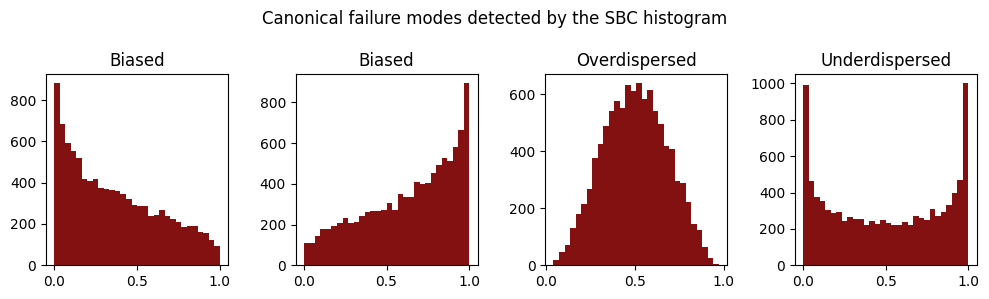

In [47]:
fig, ax = plt.subplots(figsize=(10,3), ncols=4)
bins = 30
color = "#831111"


ax[0].hist(ranks_positive_bias, bins=bins, color=color)
ax[0].set_title("Biased")
ax[1].hist(ranks_negative_bias, bins=bins, color=color)
ax[1].set_title("Biased")
ax[2].hist(ranks_overdispersed, bins=bins, color=color)
ax[2].set_title("Overdispersed")
ax[3].hist(ranks_underdispersed, bins=bins, color=color)
ax[3].set_title("Underdispersed")

plt.suptitle("Canonical failure modes detected by the SBC histogram")
plt.tight_layout()
plt.show()